In [391]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from practicum_utils import get_loggi_files, global_connect, run_query, explained_time, careful_query

In [205]:
db = global_connect()

def simulate_itineraries(today_time, ag = '1', include_previous_days = False):

    
    agency = {'1': '6e7dacf2149d053183fe901e3cfd8b82',
              '2': '58cfe3b975dd7cbd1ac84d555640bfd9'}
    
    r = {'time': today_time, 'agency_id': agency['1'], 'day': {}, 'recent': {}, 'series': {}}
    r_day = {}
    
    if simulate_itineraries.df is None:
        print('first time simulation call')
        df = careful_query("""select * from itinerary""")
        df['created_to_accept'] = df.accepted_time - df.created_time
        df['created_to_start'] = df.started_time - df.created_time
        df['created_to_finished'] = df.finished_time - df.created_time
        simulate_itineraries.df = df

    # filter to agency data
    df = simulate_itineraries.df.query("distribution_center == '{0}'".format(agency[ag]))
    
    # today_time = '2019-11-09 15:20:00'
    today_date = today_time[:10]
    today_hour = today_time[11:13]
    
    # filter itineraries of the day until today time (that were created today)
    # check if we must process itineraries not finished from previous days
    cond = ''
    if include_previous_days:
        cond = "(finished_time > '{0}' and created_time <= '{1}') or ".format(today_time, today_date)
    
    cond += "(created_time <=  '{0}' and created_time >= '{1}')".format(today_time, today_date)
    dfi = df.query(cond)
    
    r['day']['itineraries'] = dfi.itinerary_id.nunique()
    r['day']['finished'] = dfi.query("finished_time <= '{0}'".format(today_time)).itinerary_id.nunique()
    r['day']['pending'] = dfi.query("finished_time > '{0}'".format(today_time)).itinerary_id.nunique()
    r['day']['pending_acceptance'] = dfi.query("finished_time > '{0}' and accepted_time > '{0}'".format(today_time)).itinerary_id.nunique()
    r['day']['finished_avg_time'] = dfi.query("finished_time <= '{0}'".format(today_time)).created_to_finished.mean()
    r['day']['finished_std_time'] = dfi.query("finished_time <= '{0}'".format(today_time)).created_to_finished.std()
    r['day']['created_to_accept_avg_time'] = dfi.query("finished_time <= '{0}'".format(today_time)).created_to_accept.mean()
    r['day']['created_to_start_avg_time'] = dfi.query("finished_time <= '{0}'".format(today_time)).created_to_start.mean()
    
    d = pd.DataFrame(dfi.groupby(dfi.created_time.dt.hour).itinerary_id.count(), index=pd.Index(range(24)))
    r['series']['itineraries'] = d.fillna(0)
    
    d = pd.DataFrame(dfi.query("finished_time <= '{0}'".format(today_time)) \
                     .groupby(dfi.created_time.dt.hour).itinerary_id.count(), index=pd.Index(range(24)))
    r['series']['finished_by_creation_time'] = d.fillna(0)

    d = pd.DataFrame(dfi.query("finished_time <= '{0}'".format(today_time)) \
                     .groupby(dfi.finished_time.dt.hour).itinerary_id.count(), index=pd.Index(range(24)))
    r['series']['finished_by_finishing_time'] = d.fillna(0)

    d = pd.DataFrame(dfi.query("finished_time > '{0}'".format(today_time)) \
                     .groupby(dfi.created_time.dt.hour).itinerary_id.count(), index=pd.Index(range(24)))
    r['series']['pending_by_creation_time'] = d.fillna(0)
    
    
    dft = dfi.copy()
    cond = (dft.finished_time > today_time)
    dft.loc[cond, 'finished_time'] = pd.to_datetime(today_time)
    dft['created_to_finished'] = dft['finished_time'] - dft['created_time']
    r['day']['total_avg_time'] = dft.created_to_finished.mean() # include not finished until now
    r['day']['total_std_time'] = dft.created_to_finished.std() # include not finished until now

    if str(r['day']['total_std_time']) == 'NaT':
        r['day']['total_std_time'] = timedelta(0,0,0)

    if str(r['day']['total_avg_time']) == 'NaT':
        r['day']['total_avg_time'] = timedelta(0,0,0)

    if str(r['day']['created_to_accept_avg_time']) == 'NaT':
        r['day']['created_to_accept_avg_time'] = timedelta(0,0,0)

    if str(r['day']['created_to_start_avg_time']) == 'NaT':
        r['day']['created_to_start_avg_time'] = timedelta(0,0,0)

    if str(r['day']['finished_avg_time']) == 'NaT':
        r['day']['finished_avg_time'] = timedelta(0,0,0)

    if str(r['day']['finished_std_time']) == 'NaT':
        r['day']['finished_std_time'] = timedelta(0,0,0)        
        
    
    recent = 1 # hours
    d = datetime.strptime(today_time, '%Y-%m-%d %H:%M:%S') - timedelta(hours=3, minutes=0)
    previous_time = d.strftime('%Y-%m-%d %H:%M:%S')
    dfh = dfi.query("created_time >= '{0}'".format(previous_time))
    
    r['recent']['itineraries'] = dfh.itinerary_id.nunique()
    r['recent']['finished'] = dfh.query("finished_time <= '{0}'".format(today_time)).itinerary_id.nunique()
    r['recent']['pending'] = dfh.query("finished_time > '{0}'".format(today_time)).itinerary_id.nunique()
    r['recent']['finished_avg_time'] = dfh.query("finished_time <= '{0}'".format(today_time)).created_to_finished.mean()
    r['recent']['finished_std_time'] = dfh.query("finished_time <= '{0}'".format(today_time)).created_to_finished.std()
    
    if str(r['recent']['finished_avg_time']) == 'NaT':
        r['recent']['finished_avg_time'] = timedelta(0,0,0)
    
    if str(r['recent']['finished_std_time']) == 'NaT':
        r['recent']['finished_std_time'] = timedelta(0,0,0)    
    
    return r
    
simulate_itineraries.df = None

In [203]:
simulate_itineraries('2019-11-09 15:20:00', '1')

first time simulation call


{'time': '2019-11-09 15:20:00',
 'agency_id': '6e7dacf2149d053183fe901e3cfd8b82',
 'day': {'itineraries': 106,
  'finished': 82,
  'pending': 24,
  'pending_acceptance': 1,
  'finished_avg_time': Timedelta('0 days 03:12:44.512195'),
  'finished_std_time': Timedelta('0 days 01:12:02.008161'),
  'created_to_accept_avg_time': Timedelta('0 days 00:09:48.560975'),
  'created_to_start_avg_time': Timedelta('0 days 00:09:48.560975'),
  'total_avg_time': Timedelta('0 days 03:13:37.962264'),
  'total_std_time': Timedelta('0 days 01:21:07.809909')},
 'recent': {'itineraries': 15,
  'finished': 2,
  'pending': 13,
  'finished_avg_time': Timedelta('0 days 01:42:54'),
  'finished_std_time': Timedelta('0 days 01:24:12.985058')},
 'series': {'itineraries':     itinerary_id
  0            0.0
  1            0.0
  2            0.0
  3            0.0
  4            0.0
  5            0.0
  6            2.0
  7           39.0
  8           15.0
  9           17.0
  10           8.0
  11           8.0
  12

first time simulation call


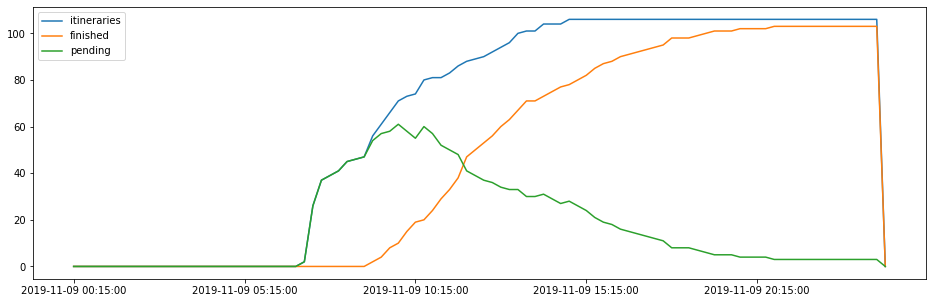

In [206]:
# simulate an entire day capturing info every 15 minutes
day_simulation = []
today_date = datetime.strptime('2019-11-09', '%Y-%m-%d')
for i in range(24*4):
    minutes = (i+1)*15
    d = today_date + timedelta(hours=0, minutes=minutes)
    today_time = d.strftime('%Y-%m-%d %H:%M:%S')   
    r = simulate_itineraries(today_time, ag='1')
    day_simulation.append(r)
    
df = pd.DataFrame({'itineraries':[sim['day']['itineraries'] for sim in day_simulation],
                   'finished':[sim['day']['finished'] for sim in day_simulation],
                   'pending':[sim['day']['pending'] for sim in day_simulation]},
                  index=[sim['time'] for sim in day_simulation])
df.plot(figsize=(16,5))
plt.legend();

Same simulation without counting previous unfinished jobs

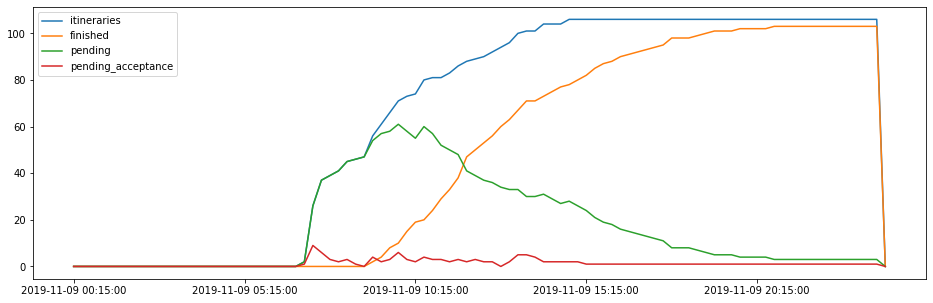

In [216]:
day_simulation = []
today_date = datetime.strptime('2019-11-09', '%Y-%m-%d')
for i in range(24*4):
    minutes = (i+1)*15
    d = today_date + timedelta(hours=0, minutes=minutes)
    today_time = d.strftime('%Y-%m-%d %H:%M:%S')   
    r = simulate_itineraries(today_time, '1', False)
    day_simulation.append(r)
    
df = pd.DataFrame({'itineraries':[sim['day']['itineraries'] for sim in day_simulation],
                   'finished':[sim['day']['finished'] for sim in day_simulation],
                   'pending':[sim['day']['pending'] for sim in day_simulation],
                   'pending_acceptance':[sim['day']['pending_acceptance'] for sim in day_simulation]},
                  index=[sim['time'] for sim in day_simulation])
df.plot(figsize=(16,5))
plt.legend();

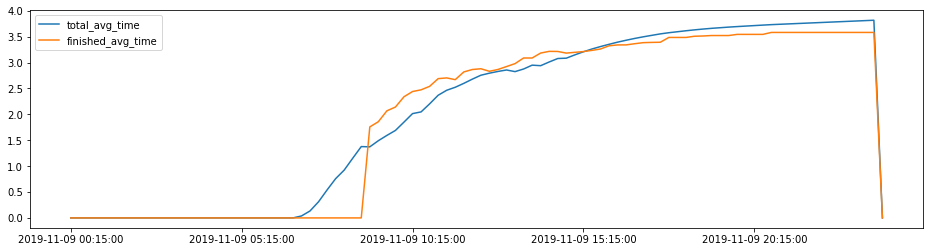

In [217]:
# how to convert times to hours
factor = 3600
df = pd.DataFrame({'total_avg_time':[sim['day']['total_avg_time'].total_seconds()/factor for sim in day_simulation],
                   'finished_avg_time':[sim['day']['finished_avg_time'].total_seconds()/factor for sim in day_simulation]},
                  index=[sim['time'] for sim in day_simulation])
df.plot(figsize=(16,4))
plt.legend();

In [386]:
# function to calculate all current situations per hour
def simulate_day(day, ag):
    day_simulation = []    
    today_date = datetime.strptime(day, '%Y-%m-%d')
    for i in range(24):
        hour = (i+1)
        d = today_date + timedelta(hours=hour, minutes=0)
        today_time = d.strftime('%Y-%m-%d %H:%M:%S')   
        r = simulate_itineraries(today_time, ag, False)
        day_simulation.append(r)
        
    return day_simulation

In [248]:
# simulate an entire month
current = datetime.strptime('2019-11-01', '%Y-%m-%d')
days = []
for i in range(30):
    print('simulating day {} ...'.format(str(current)[:10]))
    days.append(simulate_day(str(current)[:10]))
    current += timedelta(days=1)

simulating day 2019-11-01 ...
simulating day 2019-11-02 ...
simulating day 2019-11-03 ...
simulating day 2019-11-04 ...
simulating day 2019-11-05 ...
simulating day 2019-11-06 ...
simulating day 2019-11-07 ...
simulating day 2019-11-08 ...
simulating day 2019-11-09 ...
simulating day 2019-11-10 ...
simulating day 2019-11-11 ...
simulating day 2019-11-12 ...
simulating day 2019-11-13 ...
simulating day 2019-11-14 ...
simulating day 2019-11-15 ...
simulating day 2019-11-16 ...
simulating day 2019-11-17 ...
simulating day 2019-11-18 ...
simulating day 2019-11-19 ...
simulating day 2019-11-20 ...
simulating day 2019-11-21 ...
simulating day 2019-11-22 ...
simulating day 2019-11-23 ...
simulating day 2019-11-24 ...
simulating day 2019-11-25 ...
simulating day 2019-11-26 ...
simulating day 2019-11-27 ...
simulating day 2019-11-28 ...
simulating day 2019-11-29 ...
simulating day 2019-11-30 ...


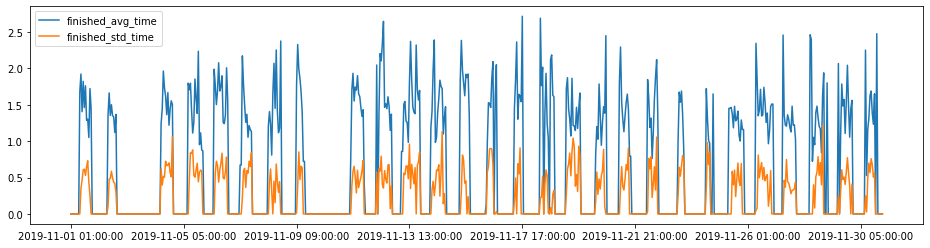

In [214]:
# no me convence esta metrica, pero basicamente es el tiempo promedio que lleva terminar
# un trabajo tomando informacion de la ultima hora.
factor = 3600
finished_avg_time = []
finished_std_time = []
index = []
for day_sim in days:
    finished_avg_time += [sim['recent']['finished_avg_time'].total_seconds()/factor for sim in day_sim]
    finished_std_time += [sim['recent']['finished_std_time'].total_seconds()/factor for sim in day_sim]
    index += [sim['time'] for sim in day_sim]

df = pd.DataFrame({'finished_avg_time': finished_avg_time,
                   'finished_std_time': finished_std_time}, index=index)
df.plot(figsize=(16,4))
plt.legend();

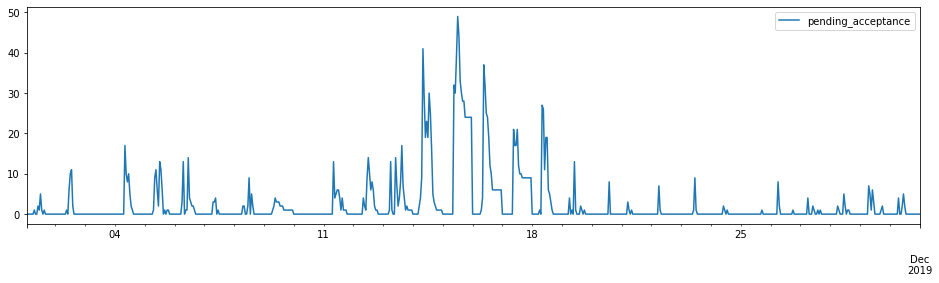

In [318]:
# itineraries accepted pending to be finished
# itineraries pending of acceptance
factor = 3600
pending = []
pending_acceptance = []
index = []
for day_sim in days:
    pending += [sim['day']['pending'] for sim in day_sim]
    pending_acceptance += [sim['day']['pending_acceptance'] for sim in day_sim]
    index += [sim['time'] for sim in day_sim]

df = pd.DataFrame({'pending': pending,
                   'pending_acceptance': pending_acceptance}, index=index)

df.index = pd.to_datetime(df.index)
df['pending_acceptance'].plot(figsize=(16,4))
plt.legend();

# max series value per hour
df.groupby(df.index.date).max().plot(figsize=(16,4));

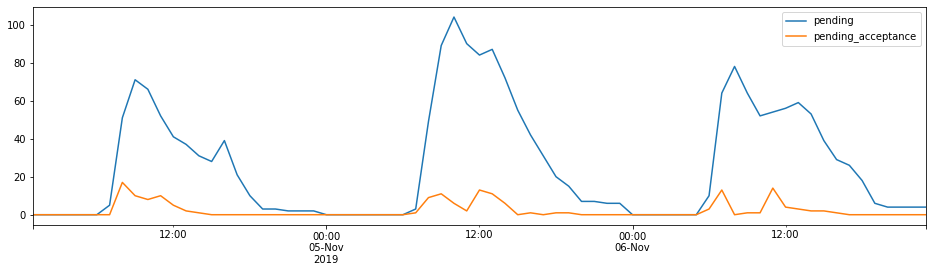

In [240]:
df[(df.index > '2019-11-04') & (df.index < '2019-11-07')].plot(figsize=(16,4));

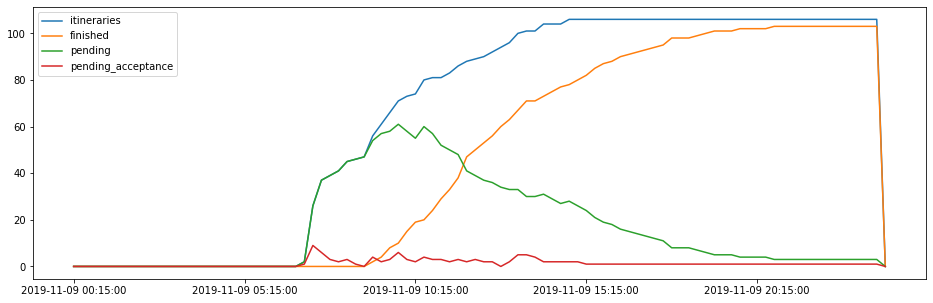

In [219]:
df = pd.DataFrame({'itineraries':[sim['day']['itineraries'] for sim in day_simulation],
                   'finished':[sim['day']['finished'] for sim in day_simulation],
                   'pending':[sim['day']['pending'] for sim in day_simulation],
                   'pending_acceptance':[sim['day']['pending_acceptance'] for sim in day_simulation]
                  },
                  index=[sim['time'] for sim in day_simulation])
df.plot(figsize=(16,5))
plt.legend();

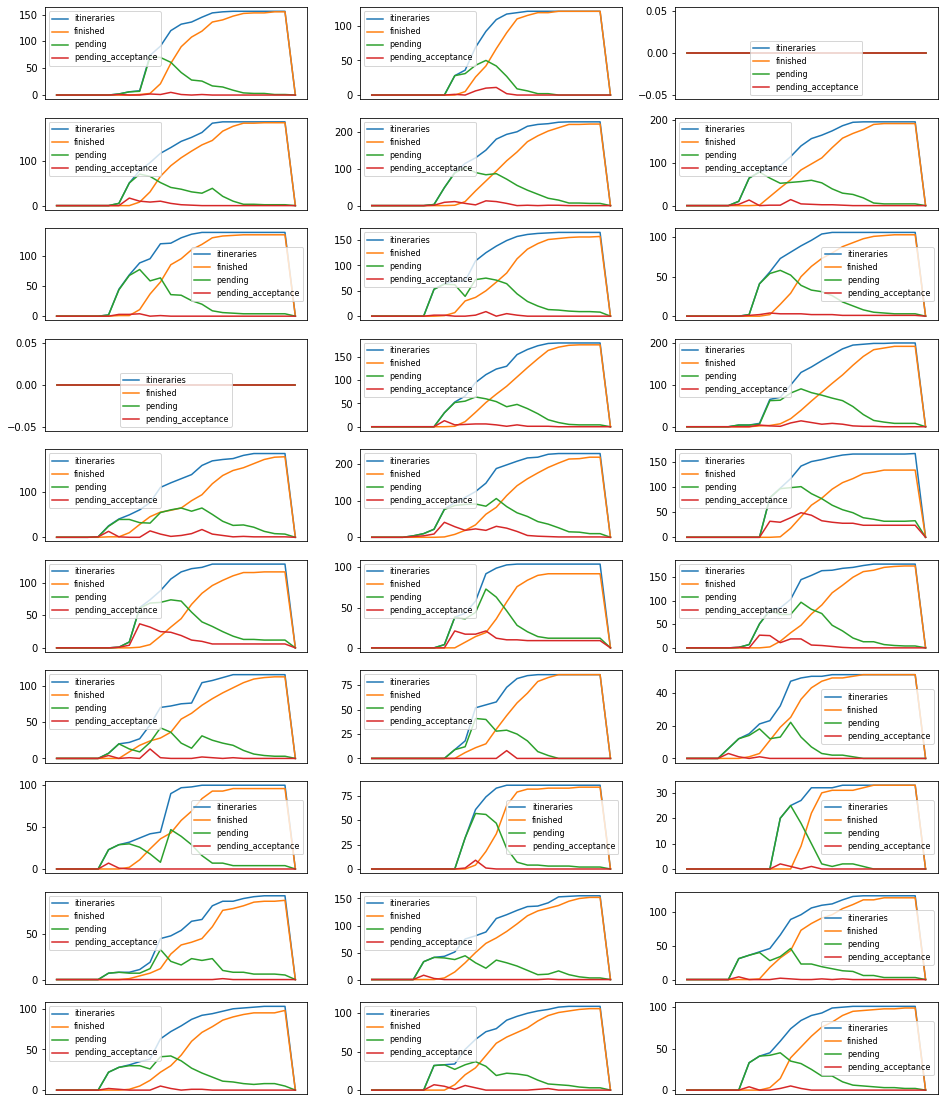

In [246]:
fig, axes = plt.subplots(10, 3, figsize=(16,20))
axes = axes.flatten()
factor = 3600
finished_avg_time = []
finished_std_time = []
index = []
for i, day_sim in enumerate(days):
    df = pd.DataFrame({'itineraries':[sim['day']['itineraries'] for sim in day_sim],
           'finished':[sim['day']['finished'] for sim in day_sim],
           'pending':[sim['day']['pending'] for sim in day_sim],
           'pending_acceptance':[sim['day']['pending_acceptance'] for sim in day_sim]
          },
          index=[sim['time'] for sim in day_sim])

    df.plot(ax=axes[i])
    axes[i].set_xticks([])
    axes[i].legend(fontsize=8);

In [313]:
today_time = '2019-11-09 15:20:00'
sim = simulate_itineraries(today_time, '1')
today_sim = simulate_day(today_time[:10]) 
prev_sim = simulate_day('2019-11-02')

In [316]:
today_df = pd.DataFrame(
      {'itineraries':[sim['day']['itineraries'] for sim in today_sim],
       'finished':[sim['day']['finished'] for sim in today_sim],
       'pending':[sim['day']['pending'] for sim in today_sim],
       'pending_acceptance':[sim['day']['pending_acceptance'] for sim in today_sim]
      },
      index=[sim['time'] for sim in today_sim])

prefix = 'last_week_'
index = [(datetime.strptime(sim['time'], '%Y-%m-%d %H:%M:%S') - timedelta(days=7)) for sim in prev_sim]
index = [str(idx) for idx in index]
previous_df = pd.DataFrame(
      {prefix + 'itineraries':[sim['day']['itineraries'] for sim in prev_sim],
       prefix + 'finished':[sim['day']['finished'] for sim in prev_sim],
       prefix + 'pending':[sim['day']['pending'] for sim in prev_sim],
       prefix + 'pending_acceptance':[sim['day']['pending_acceptance'] for sim in prev_sim]
      },
      index=index)
#

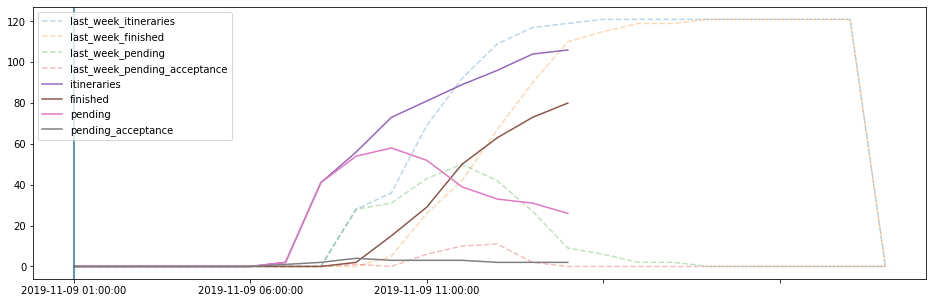

In [317]:
fig = plt.figure(figsize=(16,5))
ax = plt.subplot(111)
#d = pd.DataFrame(sim['series']['itineraries'])
#d['itineraries_accumulated'] = d['itinerary_id'].cumsum()
#d.plot(ax=ax);
previous_df.plot(ax=ax, ls='--', alpha=0.3)
today_df[today_df.index < today_time].plot(ax=ax)
ax.axvline(today_time);

# Create data set to track itineraries daily situations per hour

In [382]:
run_query("""
CREATE TABLE pending_oozma (
    distribution_center    VARCHAR(32) NOT NULL,
    date_time              VARCHAR(20) NOT NULL,
    itineraries_cumsum     INT NOT NULL,
    finished_cumsum        INT NOT NULL,
    pending                INT NOT NULL,
    pending_acceptance     INT NOT NULL,
    finished_avg_time      FLOAT NOT NULL,
    created_to_accept_avg_time    FLOAT NOT NULL,
    created_to_start_avg_time     FLOAT NOT NULL
);

ALTER TABLE pending_oozma ADD PRIMARY KEY (distribution_center, date_time);
""", df=False)

In [389]:
def simulate_itineraries(today_time, ag, include_previous_days = False):

    
    agency = {'1': '6e7dacf2149d053183fe901e3cfd8b82',
              '2': '58cfe3b975dd7cbd1ac84d555640bfd9'}
    
    r = {'time': today_time, 'agency_id': agency[ag], 'day': {}, 'recent': {}, 'series': {}}
    r_day = {}
    
    if simulate_itineraries.df is None:
        print('first time simulation call')
        df = careful_query("""select * from itinerary""")
        df['created_to_accept'] = df.accepted_time - df.created_time
        df['created_to_start'] = df.started_time - df.created_time
        df['created_to_finished'] = df.finished_time - df.created_time
        simulate_itineraries.df = df

    # filter to agency data
    df = simulate_itineraries.df.query("distribution_center == '{0}'".format(agency[ag]))
    
    # today_time = '2019-11-09 15:20:00'
    today_date = today_time[:10]
    today_hour = today_time[11:13]
    
    # filter itineraries of the day until today time (that were created today)
    # check if we must process itineraries not finished from previous days
    cond = ''
    if include_previous_days:
        cond = "(finished_time > '{0}' and created_time <= '{1}') or ".format(today_time, today_date)
    
    cond += "(created_time <=  '{0}' and created_time >= '{1}')".format(today_time, today_date)
    dfi = df.query(cond)
    
    r['day']['itineraries'] = dfi.itinerary_id.nunique()
    r['day']['finished'] = dfi.query("finished_time <= '{0}'".format(today_time)).itinerary_id.nunique()
    r['day']['pending'] = dfi.query("finished_time > '{0}'".format(today_time)).itinerary_id.nunique()
    r['day']['pending_acceptance'] = dfi.query("finished_time > '{0}' and accepted_time > '{0}'".format(today_time)).itinerary_id.nunique()
    r['day']['finished_avg_time'] = dfi.query("finished_time <= '{0}'".format(today_time)).created_to_finished.mean()
    r['day']['created_to_accept_avg_time'] = dfi.query("finished_time <= '{0}'".format(today_time)).created_to_accept.mean()
    r['day']['created_to_start_avg_time'] = dfi.query("finished_time <= '{0}'".format(today_time)).created_to_start.mean()
            
    dft = dfi.copy()
    cond = (dft.finished_time > today_time)
    dft.loc[cond, 'finished_time'] = pd.to_datetime(today_time)
    dft['created_to_finished'] = dft['finished_time'] - dft['created_time']
    r['day']['total_avg_time'] = dft.created_to_finished.mean() # include not finished until now
    r['day']['total_std_time'] = dft.created_to_finished.std() # include not finished until now

    if str(r['day']['total_std_time']) == 'NaT':
        r['day']['total_std_time'] = timedelta(0,0,0)

    if str(r['day']['total_avg_time']) == 'NaT':
        r['day']['total_avg_time'] = timedelta(0,0,0)

    if str(r['day']['created_to_accept_avg_time']) == 'NaT':
        r['day']['created_to_accept_avg_time'] = timedelta(0,0,0)

    if str(r['day']['created_to_start_avg_time']) == 'NaT':
        r['day']['created_to_start_avg_time'] = timedelta(0,0,0)

    if str(r['day']['finished_avg_time']) == 'NaT':
        r['day']['finished_avg_time'] = timedelta(0,0,0)
        
    return r
    
simulate_itineraries.df = None

In [355]:
dfi = careful_query("""
select distribution_center,
min(created_time) as mi,
max(created_time) as ma
from itinerary group by distribution_center""")

In [356]:
dfi

,distribution_center,mi,ma
0,58cfe3b975dd7cbd1ac84d555640bfd9,2019-10-22 07:53:35,2020-03-25 12:00:41
1,6e7dacf2149d053183fe901e3cfd8b82,2019-09-30 07:29:15,2020-03-25 17:55:06


In [357]:
agency = {'1': '6e7dacf2149d053183fe901e3cfd8b82',
          '2': '58cfe3b975dd7cbd1ac84d555640bfd9'}

In [358]:
dfi[dfi.distribution_center == agency['1']]

,distribution_center,mi,ma
1,6e7dacf2149d053183fe901e3cfd8b82,2019-09-30 07:29:15,2020-03-25 17:55:06


In [378]:
def save_in_db(rows):
    
    for row in rows:
        insert = """
        INSERT INTO pending_oozma  (distribution_center, date_time, itineraries_cumsum,
                    finished_cumsum, pending, pending_acceptance, finished_avg_time,
                    created_to_accept_avg_time, created_to_start_avg_time) VALUES ({})"""

        values = "'{}', ".format(row['agency_id'])
        values += "'{}', ".format(row['time'])
        values += "'{}', ".format(row['day']['itineraries'])
        values += "'{}', ".format(row['day']['finished'])
        values += "'{}', ".format(row['day']['pending'])
        values += "'{}', ".format(row['day']['pending_acceptance'])
        values += "'{}', ".format(row['day']['finished_avg_time'].total_seconds())
        values += "'{}', ".format(row['day']['created_to_accept_avg_time'].total_seconds())
        values += "'{}' ".format(row['day']['created_to_start_avg_time'].total_seconds())
        print('', end='.')
        insert = insert.format(values)
        r = run_query(insert, df=False)

    print('')
    

In [384]:
current = datetime.strptime('2019-10-01', '%Y-%m-%d')
until = datetime.strptime('2020-03-25', '%Y-%m-%d')
ag = '1'
for i in range(1000):
    print('simulating day {} ...'.format(str(current)[:10]), end='')    
    sim_day = simulate_day(str(current)[:10], ag=ag)
    print('saving...', end='')    
    save_in_db(sim_day)
    current += timedelta(days=1)
    if current == until:
        break



simulating day 2019-10-01 ...saving...........................
simulating day 2019-10-02 ...saving...........................
simulating day 2019-10-03 ...saving...........................
simulating day 2019-10-04 ...saving...........................
simulating day 2019-10-05 ...saving...........................
simulating day 2019-10-06 ...saving...........................
simulating day 2019-10-07 ...saving...........................
simulating day 2019-10-08 ...saving...........................
simulating day 2019-10-09 ...saving...........................
simulating day 2019-10-10 ...saving...........................
simulating day 2019-10-11 ...saving...........................
simulating day 2019-10-12 ...saving...........................
simulating day 2019-10-13 ...saving...........................
simulating day 2019-10-14 ...saving...........................
simulating day 2019-10-15 ...saving...........................
simulating day 2019-10-16 ...saving....................

In [390]:
current = datetime.strptime('2019-10-23', '%Y-%m-%d')
until = datetime.strptime('2020-03-25', '%Y-%m-%d')
ag = '2'
for i in range(1000):
    print('simulating day {} ...'.format(str(current)[:10]), end='')    
    sim_day = simulate_day(str(current)[:10], ag=ag)
    print('saving...', end='')    
    save_in_db(sim_day)
    current += timedelta(days=1)
    if current == until:
        break

simulating day 2019-10-23 ...first time simulation call
saving...........................
simulating day 2019-10-24 ...saving...........................
simulating day 2019-10-25 ...saving...........................
simulating day 2019-10-26 ...saving...........................
simulating day 2019-10-27 ...saving...........................
simulating day 2019-10-28 ...saving...........................
simulating day 2019-10-29 ...saving...........................
simulating day 2019-10-30 ...saving...........................
simulating day 2019-10-31 ...saving...........................
simulating day 2019-11-01 ...saving...........................
simulating day 2019-11-02 ...saving...........................
simulating day 2019-11-03 ...saving...........................
simulating day 2019-11-04 ...saving...........................
simulating day 2019-11-05 ...saving...........................
simulating day 2019-11-06 ...saving...........................
simulating day 2019-11-07 ..

simulating day 2020-03-01 ...saving...........................
simulating day 2020-03-02 ...saving...........................
simulating day 2020-03-03 ...saving...........................
simulating day 2020-03-04 ...saving...........................
simulating day 2020-03-05 ...saving...........................
simulating day 2020-03-06 ...saving...........................
simulating day 2020-03-07 ...saving...........................
simulating day 2020-03-08 ...saving...........................
simulating day 2020-03-09 ...saving...........................
simulating day 2020-03-10 ...saving...........................
simulating day 2020-03-11 ...saving...........................
simulating day 2020-03-12 ...saving...........................
simulating day 2020-03-13 ...saving...........................
simulating day 2020-03-14 ...saving...........................
simulating day 2020-03-15 ...saving...........................
simulating day 2020-03-16 ...saving....................

# Create CSV

In [392]:
db = global_connect()

In [393]:
df = careful_query('select * from pending_oozma')

In [395]:
df.to_csv('pending_oozma.csv')

In [418]:
df = careful_query("""
select * from pending_oozma
where date_time >= '2020-01-16 00:00:00'
  and date_time <  '2020-01-17 00:00:00'
group by distribution_center, date_time
""")

df.set_index('date_time', drop=True, inplace=True)

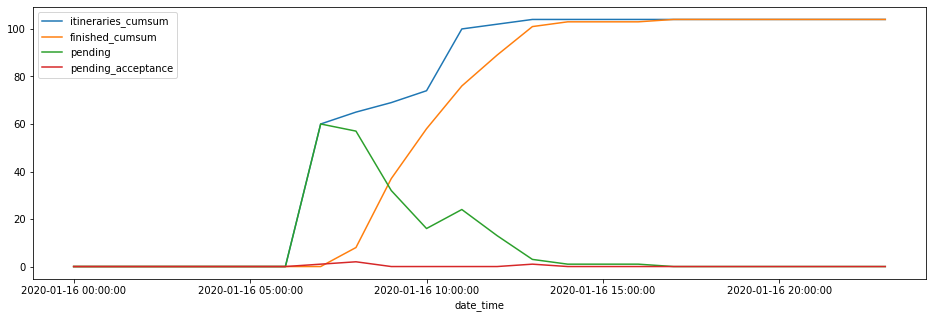

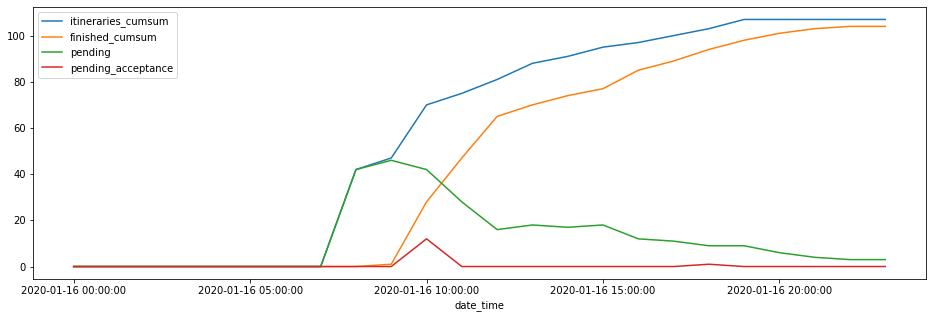

In [420]:
df.groupby('distribution_center')[['itineraries_cumsum','finished_cumsum','pending','pending_acceptance']].plot(figsize=(16,5));

In [425]:
def get_hourly_day_itineraries(agency_id, today_time):
    
    today = today_time[:10]
    #today_date = datetime.strptime(today, '%Y-%m-%d')    
    #tomorrow_date = today_date + timedelta(days=1) 
    #tomorrow = str(tomorrow_date)[:10]
    
    df = careful_query("""
        select * from pending_oozma
        where date_time >= '{1}'
          and date_time <  '{2}'
          and distribution_center = '{0}'
        --group by distribution_center, date_time
        order by date_time asc
        """.format(agency_id, today, today_time))
    

    df.set_index('date_time', drop=True, inplace=True)
    
    return df

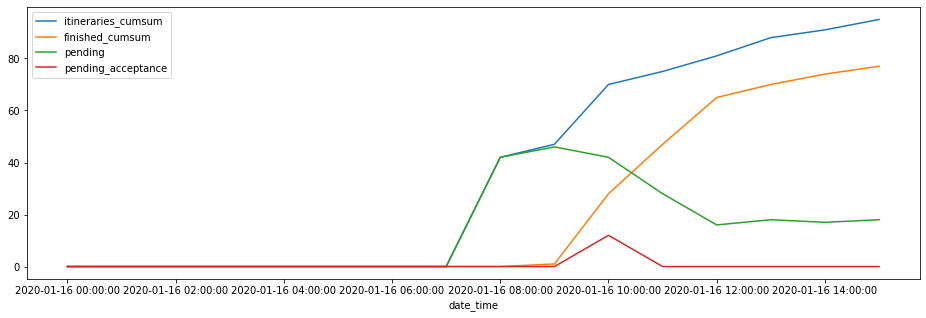

In [426]:
df = get_hourly_day_itineraries(agency['1'], today_time='2020-01-16 15:27:20')
df[['itineraries_cumsum','finished_cumsum','pending','pending_acceptance']].plot(figsize=(16,5));

In [453]:
#df[['finished_avg_time', 'created_to_accept_avg_time']].plot();
df[['created_to_accept_avg_time']]

,created_to_accept_avg_time
date_time,
2020-01-16 00:00:00,0.000000
2020-01-16 01:00:00,0.000000
2020-01-16 02:00:00,0.000000
2020-01-16 03:00:00,0.000000
2020-01-16 04:00:00,0.000000
2020-01-16 05:00:00,0.000000
2020-01-16 06:00:00,0.000000
2020-01-16 07:00:00,0.000000
2020-01-16 08:00:00,0.000000


In [454]:
df[['finished_avg_time']]

,finished_avg_time
date_time,
2020-01-16 00:00:00,0.000000
2020-01-16 01:00:00,0.000000
2020-01-16 02:00:00,0.000000
2020-01-16 03:00:00,0.000000
2020-01-16 04:00:00,0.000000
2020-01-16 05:00:00,0.000000
2020-01-16 06:00:00,0.000000
2020-01-16 07:00:00,0.000000
2020-01-16 08:00:00,0.000000


In [456]:
str(timedelta(seconds=666))

'0:11:06'

In [463]:
df['finished_avg_time'].apply(lambda x: str(timedelta(seconds=int(x))))

date_time
2020-01-16 00:00:00    0:00:00
2020-01-16 01:00:00    0:00:00
2020-01-16 02:00:00    0:00:00
2020-01-16 03:00:00    0:00:00
2020-01-16 04:00:00    0:00:00
2020-01-16 05:00:00    0:00:00
2020-01-16 06:00:00    0:00:00
2020-01-16 07:00:00    0:00:00
2020-01-16 08:00:00    0:00:00
2020-01-16 09:00:00    1:55:02
2020-01-16 10:00:00    2:15:55
2020-01-16 11:00:00    2:21:45
2020-01-16 12:00:00    2:19:19
2020-01-16 13:00:00    2:20:18
2020-01-16 14:00:00    2:21:13
2020-01-16 15:00:00    2:22:10
Name: finished_avg_time, dtype: object

In [464]:
df['created_to_accept_avg_time'].apply(lambda x: str(timedelta(seconds=int(x))))

date_time
2020-01-16 00:00:00    0:00:00
2020-01-16 01:00:00    0:00:00
2020-01-16 02:00:00    0:00:00
2020-01-16 03:00:00    0:00:00
2020-01-16 04:00:00    0:00:00
2020-01-16 05:00:00    0:00:00
2020-01-16 06:00:00    0:00:00
2020-01-16 07:00:00    0:00:00
2020-01-16 08:00:00    0:00:00
2020-01-16 09:00:00    0:00:47
2020-01-16 10:00:00    0:01:43
2020-01-16 11:00:00    0:01:38
2020-01-16 12:00:00    0:03:00
2020-01-16 13:00:00    0:03:16
2020-01-16 14:00:00    0:03:17
2020-01-16 15:00:00    0:03:14
Name: created_to_accept_avg_time, dtype: object